# Shifts and Lags

In [ ]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)
library(VIM)

# library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [3]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

In [4]:
country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

In [5]:
df[, ctry := factor(ctry, labels=country_labels)]

In [222]:
# intrapolation?
# x <- 1:10
# y <- rnorm(10)

# plot(x, y, main = "approx(.) and approxfun(.)")
# # points(approx(x, y), col = 2, pch = "*")
# points(approx(y, method = "linear"), col = 4, pch = "*")

# Only male-female average and records since 1900

In [15]:
covariates = names(df)[10:28]

In [22]:
c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max), 
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

In [33]:
(nrow(c) + nrow(le))/2

[1] 1848

In [30]:
dt = merge(c, le, by=c('ctry', 'year'))

In [55]:
print(countmis(dt))

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


In [56]:
library(mice)

In [61]:
test = mice(dt, m=10, method='cart', printFlag=FALSE)

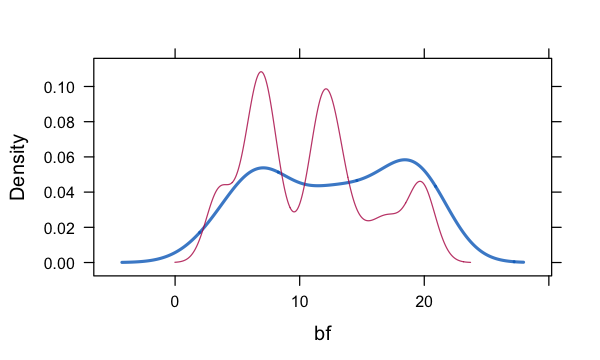

In [60]:
densityplot(test, ~bf)

In [259]:
# missing data?
# total = total[complete.cases(total[, .(Ex, gdp_pc)])]

# total= total[, .(ctry, year, gdp_pc, Ex)]
# setnames(total, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [260]:
dt[, le_log := scale(log(le), scale=FALSE)]
dt[, gdp_log := scale(log(gdp), scale=FALSE)]
total[, year_log := scale(log(year), scale=FALSE)]

In [261]:
# year recode based on the criteria proposed by Alberto
total[year<1950, gyear:=1]
total[year>=1950 & year<1970, gyear:=2]
total[year>=1970 & year<1990, gyear:=3]
total[year>=1990, gyear :=4]
total[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [262]:
# transform variable: weibull
total[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
total[, wy := log(-log(1-y))]

In [263]:
max_le_total = total[, .(max_le = max(le+1.05)), by = ctry]

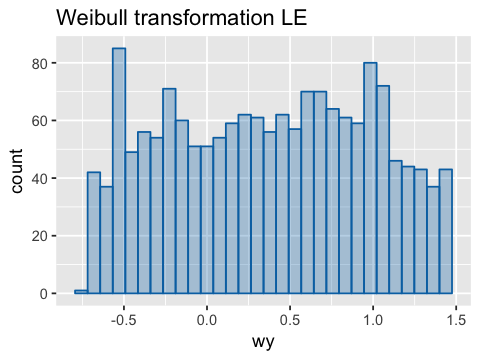

In [264]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(total, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

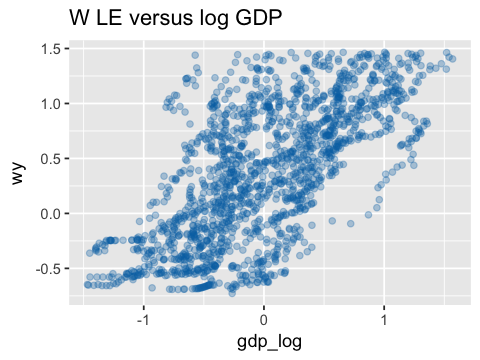

In [265]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(total, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Total Model

In [266]:
# check sample sizes
total[, ctry_year := interaction(ctry, gyear)]

In [267]:
t1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = total)

Compiling the C++ model
Start sampling


In [269]:
summary(t1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: total (Number of observations: 1657) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.55      0.05     0.46     0.66        548 1.01
sd(gdp_log)                0.70      0.07     0.58     0.85       1187 1.00
cor(Intercept,gdp_log)     0.09      0.13    -0.17     0.34        799 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.41      0.07     0.28     0.53        480 1.01
gdp_log       0.75      0.09     0.58     0.92        795 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00

### Examine GOF

In [379]:
pred = cbind(total[, .(ctry, year, le, gdp_log, le_log)], predict(t1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [380]:
pred = merge(pred, max_le_total, by = 'ctry')

In [381]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [382]:
pred_total = pred

In [275]:
max_ex = max(total$le)+25.0
min_ex = min(total$le)-25.0
max_year = max(total$year)
min_year = min(total$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

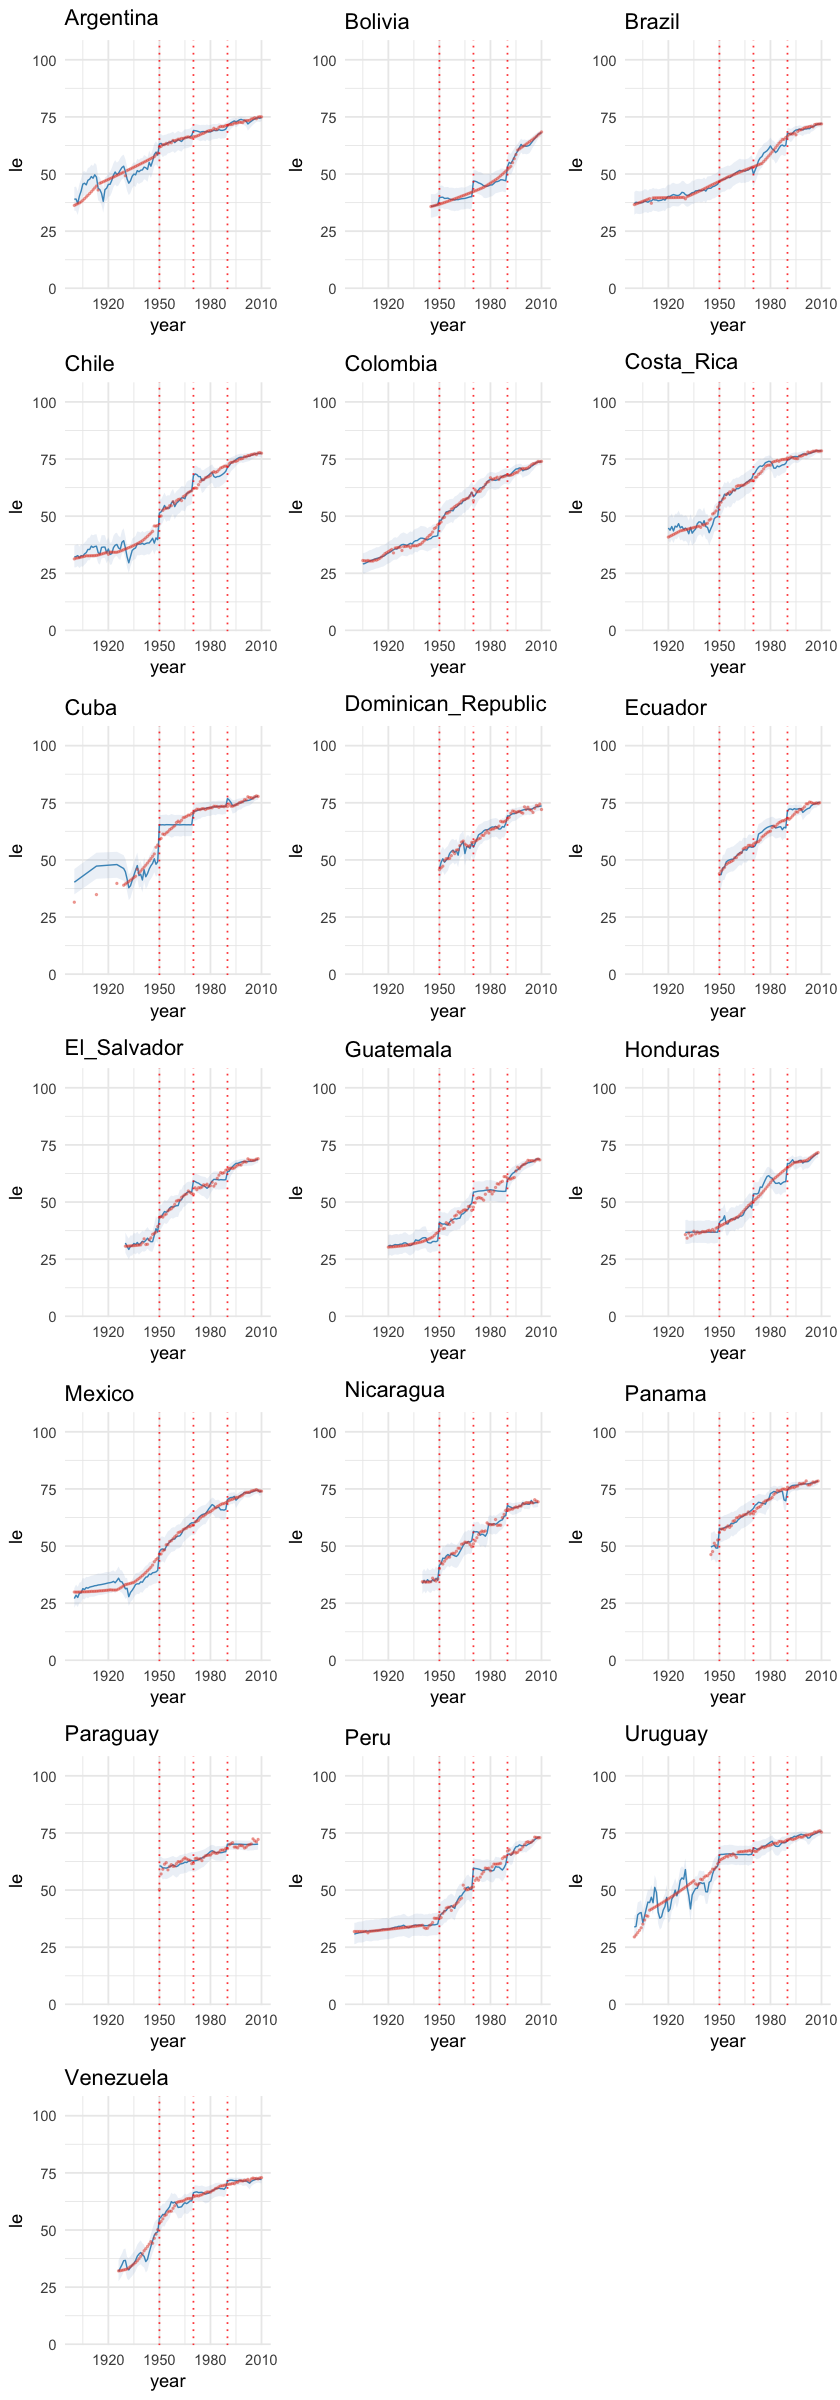

In [276]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

In [405]:
# get predictions
# pred_male[, sex := 'male']
# pred_female[, sex := 'female']
# pred_total[, sex := 'total']

# pred = rbind(pred_male, pred_female, pred_total)
fwrite(pred_total[, .(ctry, year, le, m, lo, hi)], '../dash/data/pred.csv')

# Compute shifts

In [396]:
estimate_shift = function(samples,
                          gdp_value=NULL,
                          le_value=NULL,
                          country=NULL, 
                          model_year=NULL,
                          year=NULL,
                          max_le = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
                          
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]  
    
    pred = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pred = unlist(sapply(pred, function(x) get_orig_values_weibull(x, max_value=max_le)))
    
    return(le_value-pred)           
}

In [397]:
test1 = estimate_shift(samples=posterior_samples(m1), 
               country='Argentina',
               le_value=male[ctry=='Argentina' & year==1950,le],
               gdp_value=male[ctry=='Argentina' & year==1950, gdp_log],
               year=1950, 
               model_year='1950',
               max_le=max_le_male[ctry=='Argentina', max_le])

In [398]:
compute_shifts = function(model, 
                          data, 
                          country_labels,
                          iyears, 
                          max_le,
                          coefficients,
                          predicted_le=FALSE) {
        
    samples = posterior_samples(model)
    colnames = names(samples)

    model_pred = list('1950' = '1950-1969', '1970' = '1970-1989', '1990' = '1990', '2010'= '1990')
    
    shifts = list()

    for (c in country_labels) {
        
        years = as.numeric(data[ctry==c & year %in% iyears, year])
        segments = as.character(unique(data[ctry==c, gyear])) 
        max_le_value = max_le[ctry==c, max_le]
        
        for (ys in years) {
            
             fsegments = segments[-which(segments == model_pred[[as.character(ys)]])]
            
             if (predicted_le) {
                 
                 betas = paste0('b_', coefficients)
                 my = model_pred[[as.character(ys)]]
     
                 random = str_subset(colnames, paste0('^r_.+\\[', c, '.', my, ','))
                 s = samples[, c(betas, random)]
    
                 gdp_log = data[ctry==c & year==ys, gdp_log]
                 
                 le_value = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_log[1]
                 
                 le_value = unlist(sapply(le_value, function(x) 
                     get_orig_values_weibull(x, max_value=max_le_value)))
            } 
            else {
                le_value = data[ctry==c & year==ys, le][1]
            }
                                          
            for (ysm in fsegments) {
               
               est = estimate_shift(samples=samples, 
                   le_value=le_value, 
                   gdp_value = data[ctry==c & year==ys, gdp_log],
                   country=c, 
                   year=ys, 
                   model_year=ysm,
                   max_le=max_le_value, 
                   coefficients=coefficients)
            
            name = paste0(c(c,ys,ysm), collapse='.')
            shifts[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_shift = est)
                
            }
        }   
        
     }
       shifts = rbindlist(shifts)
       shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

       levels = c('1990', '1970-1989', '1950-1969', '1950')
       labels = c('>=1990', '1970-1989', '1950-1969', '<1950')
       shifts[, segment := factor(segment, levels=levels, 
                             labels=labels ) ] 

        return(shifts)
}

In [399]:
iyears = c(1950, 1970, 1990, 2010)

In [400]:
shift_male_pred = compute_shifts(model=m1, 
                             data=male, 
                             country_labels=country_labels[1], 
                             iyears=iyears[1],
                             max_le=max_le_male, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [370]:
table(shift_male_pred[ctry=='Argentina' & year==1950, segment])


   >=1990 1970-1989 1950-1969     <1950 
     4000      4000         0      4000 

In [323]:
summary(shift_male_pred)

     name             pred_shift          ctry               year          
 Length:16000       Min.   :-12.656   Length:16000       Length:16000      
 Class :character   1st Qu.: -5.047   Class :character   Class :character  
 Mode  :character   Median :  0.000   Mode  :character   Mode  :character  
                    Mean   : -1.234                                        
                    3rd Qu.:  2.195                                        
                    Max.   :  8.515                                        
      segment    
 >=1990   :4000  
 1970-1989:4000  
 1950-1969:4000  
 <1950    :4000  
                 
                 

In [292]:
shift_male_obs = compute_shifts(model=m1, 
                             data=male, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_male, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_male_pred = compute_shifts(model=m1, 
                             data=male, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_male, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [282]:
shift_female_obs = compute_shifts(model=f1, 
                             data=female, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_female, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_female_pred = compute_shifts(model=f1, 
                             data=female, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_female, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [401]:
shift_total_obs = compute_shifts(model=t1, 
                             data=total, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_total, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_total_pred = compute_shifts(model=t1, 
                             data=total, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_total, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [325]:
# shift_total_pred = compute_shifts(model=t1, 
#                              data=total, 
#                              country_labels=country_labels[1], 
#                              iyears=iyears[1],
#                              max_le=max_le_total, 
#                              coefficients = c('Intercept', 'gdp_log'),
#                              predicted_le=TRUE)

In [345]:
# head(table(shift_total_pred[segment=='1950-1969', pred_shift]))


  -10.66588213407 -10.5345905990107 -10.2295727072087 -10.1731807006659 
                1                 1                 1                 1 
-9.95705925390492 -9.95561004207085 
                1                 1 

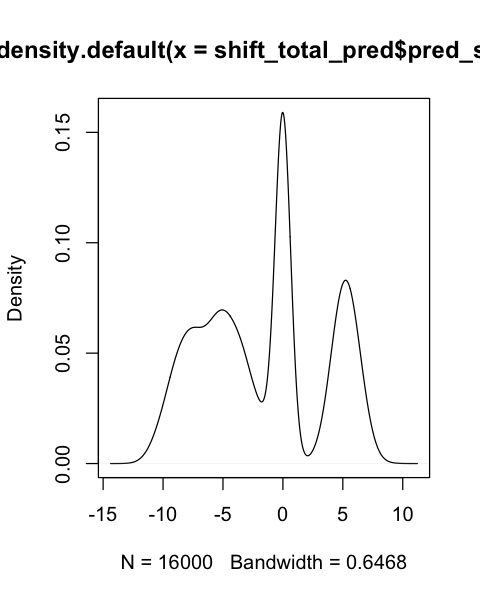

In [334]:
options(repr.plot.width = 4, repr.plot.height = 5)
plot(density(shift_total_pred$pred_shift))

In [294]:
# shift_male_obs[, sex := 'male']
# shift_male_pred[, sex := 'male']

# shift_female_obs[, sex := 'female']
# shift_female_pred[, sex := 'female']

# shift_total_obs[, sex := 'total']
# shift_total_pred[, sex := 'total']

In [295]:
# shift_obs = rbind(shift_total_obs, shift_male_obs, shift_female_obs)
# shift_pred = rbind(shift_total_pred, shift_male_pred, shift_female_pred)

In [42]:
# head(shift_male_obs, 5)
# head(shift_male_pred, 5)

In [296]:
dim(shift_obs)

[1] 3096000       6

In [297]:
dim(shift_pred)

[1] 3096000       6

In [298]:
# sample_shift_pred = shift_pred[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, segment, sex)]
# sample_shift_obs = shift_obs[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, segment, sex)]

In [299]:
# sample values to increase speed of app
# fwrite(sample_shift_pred[sex=='total',.(ctry, year, segment, sex, pred_shift)], 'shifts_pred.csv')
# fwrite(sample_shift_obs[sex=='total',.(ctry, year, segment, sex, pred_shift)], 'shifts_obs.csv')

In [404]:
fwrite(shift_total_pred[,.(ctry, year, segment, pred_shift)], '../dash/data/shifts_pred.csv')
fwrite(shift_total_obs[,.(ctry, year, segment, pred_shift)], '../dash/data/shifts_obs.csv')

# Lags

In [443]:
estimate_lags = function(samples, 
                         country=NULL, 
                         model_year=NULL,
                         le_values=NULL,
                         year_values=NULL,
                         year=NULL,
                         gdp_value = NULL, 
                         max_le_value = NULL,
                         coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))

    s = samples[, c(betas, random)]

    pred = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pred = unlist(sapply(pred, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
     
    ind = NULL
    for (i in 1:length(pred)) {
        ind[i] = which.min(abs(le_values - pred[i]))
        }
           
    return(year_values[ind]-year)
}

In [444]:
# head(total)

In [445]:
test = estimate_lags(samples=posterior_samples(t1), 
             country='Argentina', 
             model_year='1950', 
             le_values=total[ctry=='Argentina', le], 
             year_values=total[ctry=='Argentina', year],
             year=1950, 
             gdp_value=total[ctry=='Argentina' & year==1950, gdp_log], 
             max_le_value=max_le_total[ctry=='Argentina', max_le])  

In [450]:
compute_lags = function(model,
                        data, 
                        country_labels, 
                        iyears,
                        max_le, 
                        predicted_le=FALSE, 
                        coefficients) {

    model_years = list('1950' = '1950-1969', '1970' = '1970-1989', '1990' = '1990', '2010' = '1990')
    samples = posterior_samples(model)
    
    lags = list()

    for (c in country_labels) {
    
    max_le_value = max_le[ctry==c, max_le]
    iyears = as.numeric(data[ctry==c & year %in% iyears, year])
    segments = as.character(unique(data[ctry==c, gyear]))
        
      if (predicted_le) {
          le_values = predict(model, data[ctry==c], summary=FALSE)
          le_values = apply(le_values, 2, mean)
          
          le_values = unlist(lapply(le_values,  function(x) 
              get_orig_values_weibull(x, max_le_value)))
          year_values = data[ctry==c, year]
        } 
        else { 
            le_values = data[ctry==c, le]
            year_values = data[ctry==c, year]       
        }
    
    for (ys in iyears) {
        
            fsegments = segments[-which(segments == model_pred[[as.character(ys)]])]
            gdp_value= data[ctry==c & year==ys, gdp_log]
        
        for (ysm in fsegments) { 
         
            est = estimate_lags(samples=samples, 
                         country=c, 
                         model_year=ysm,
                         year=ys,
                         le_values=le_values,
                         year_values=year_values,
                         gdp_value=gdp_value, 
                         max_le_value=max_le_value,
                     )

                name = paste0(c(c,ys,ysm), collapse='.')
                lags[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_lag = est)

                  }
            }
    }
       lags = rbindlist(lags)
       lags[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

       return(lags)
}

In [462]:
iyears = c(1950, 1970, 1990, 2010)

In [463]:
lags_total_obs = compute_lags(model=t1, 
                        data=total, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_total, 
                        predicted_le=FALSE)

In [464]:
lags_total_pred = compute_lags(model=m1, 
                        data=male, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_total, 
                        predicted_le=TRUE)

# lags_total_obs[, sex := 'total']
# lags_total_pred[, sex := 'total']

In [199]:
# lags_male_obs = compute_lags(model=m1, 
#                         data=male, 
#                         country_labels=country_labels, 
#                         iyears=iyears,
#                         max_le=max_le_male, 
#                         predicted_le=FALSE)

# lags_male_pred = compute_lags(model=m1, 
#                         data=male, 
#                         country_labels=country_labels, 
#                         iyears=iyears,
#                         max_le=max_le_male, 
#                         predicted_le=TRUE)

# lags_male_obs[, sex := 'male']
# lags_male_pred[, sex := 'male']

In [200]:
# lags_female_obs = compute_lags(model=f1, 
#                         data=female, 
#                         country_labels=country_labels, 
#                         iyears=iyears,
#                         max_le=max_le_female, 
#                         predicted_le=FALSE)

# lags_female_pred = compute_lags(model=f1, 
#                         data=female, 
#                         country_labels=country_labels, 
#                         iyears=iyears,
#                         max_le=max_le_female, 
#                         predicted_le=TRUE)

# lags_female_obs[, sex := 'female']
# lags_female_pred[, sex := 'female']

In [202]:
# lags_obs = rbind(lags_total_obs, lags_male_obs, lags_female_obs)
# lags_pred = rbind(lags_total_pred, lags_male_pred, lags_female_pred)

In [459]:
dim(lags_total_obs)

[1] 648000      5

In [468]:
table(lags_total_pred$segment)


     1950 1950-1969 1970-1989      1990 
   216000    176000    176000    152000 

In [466]:
head(lags_total_pred)

name,pred_lag,ctry,year,segment
Argentina.1950.1950,-1,Argentina,1950,1950
Argentina.1950.1950,-1,Argentina,1950,1950
Argentina.1950.1950,-4,Argentina,1950,1950
Argentina.1950.1950,-1,Argentina,1950,1950
Argentina.1950.1950,-1,Argentina,1950,1950
Argentina.1950.1950,-1,Argentina,1950,1950


In [205]:
# sample_lags_pred = lags_pred[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, sex)]
# sample_lags_obs = lags_obs[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, sex)]

In [469]:
# sample values to increase speed of app
fwrite(lags_total_pred[,.(ctry, year, segment, pred_lag)], '../dash/data/lags_pred.csv')
fwrite(lags_total_obs[,.(ctry, year, segment, pred_lag)], '../dash/data/lags_obs.csv')